In [1]:
import os
import logging
from pathlib import Path
import datetime

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim
from torchinfo import summary

import torchmetrics

import cv2

import config
import dataset_dfire
import datasets
import models
import loss
import metrics
import train_epoch_qat
import val_epoch
import utils

from neural_compressor import QuantizationAwareTrainingConfig
from neural_compressor.config import AccuracyCriterion, TuningCriterion
from neural_compressor.training import prepare_compression, fit

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.11 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = config.LOGS_FOLDER

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny.\n' +  
            '\tOne Head.\n' +
            '\t255 Normalization.\n' +
            '\tWeighted for Precision.\n' +
            '\tModules.\n'+ 
            '\tLosses and Metrics Loggers.\n' +
            '\tMore checkpoints.\n' +
            '\tQAT with Neural Compressor.\n' +
            '\tTuning.\n' +
            '\tFASDD Dataset included.\n' +
            f'\tEpochs = {config.EPOCHS}')

# View Dataset

### Transform

In [4]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [5]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = dataset_dfire.DFireDataset(
    img_h=config.IMG_H, 
    img_w=config.IMG_W, 
    img_dir=config.val_imgs, 
    label_dir=config.val_labels, 
    num_classes=config.N_CLASSES,
    ds_len=2*VIEW_BATCH_SIZE,
    transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

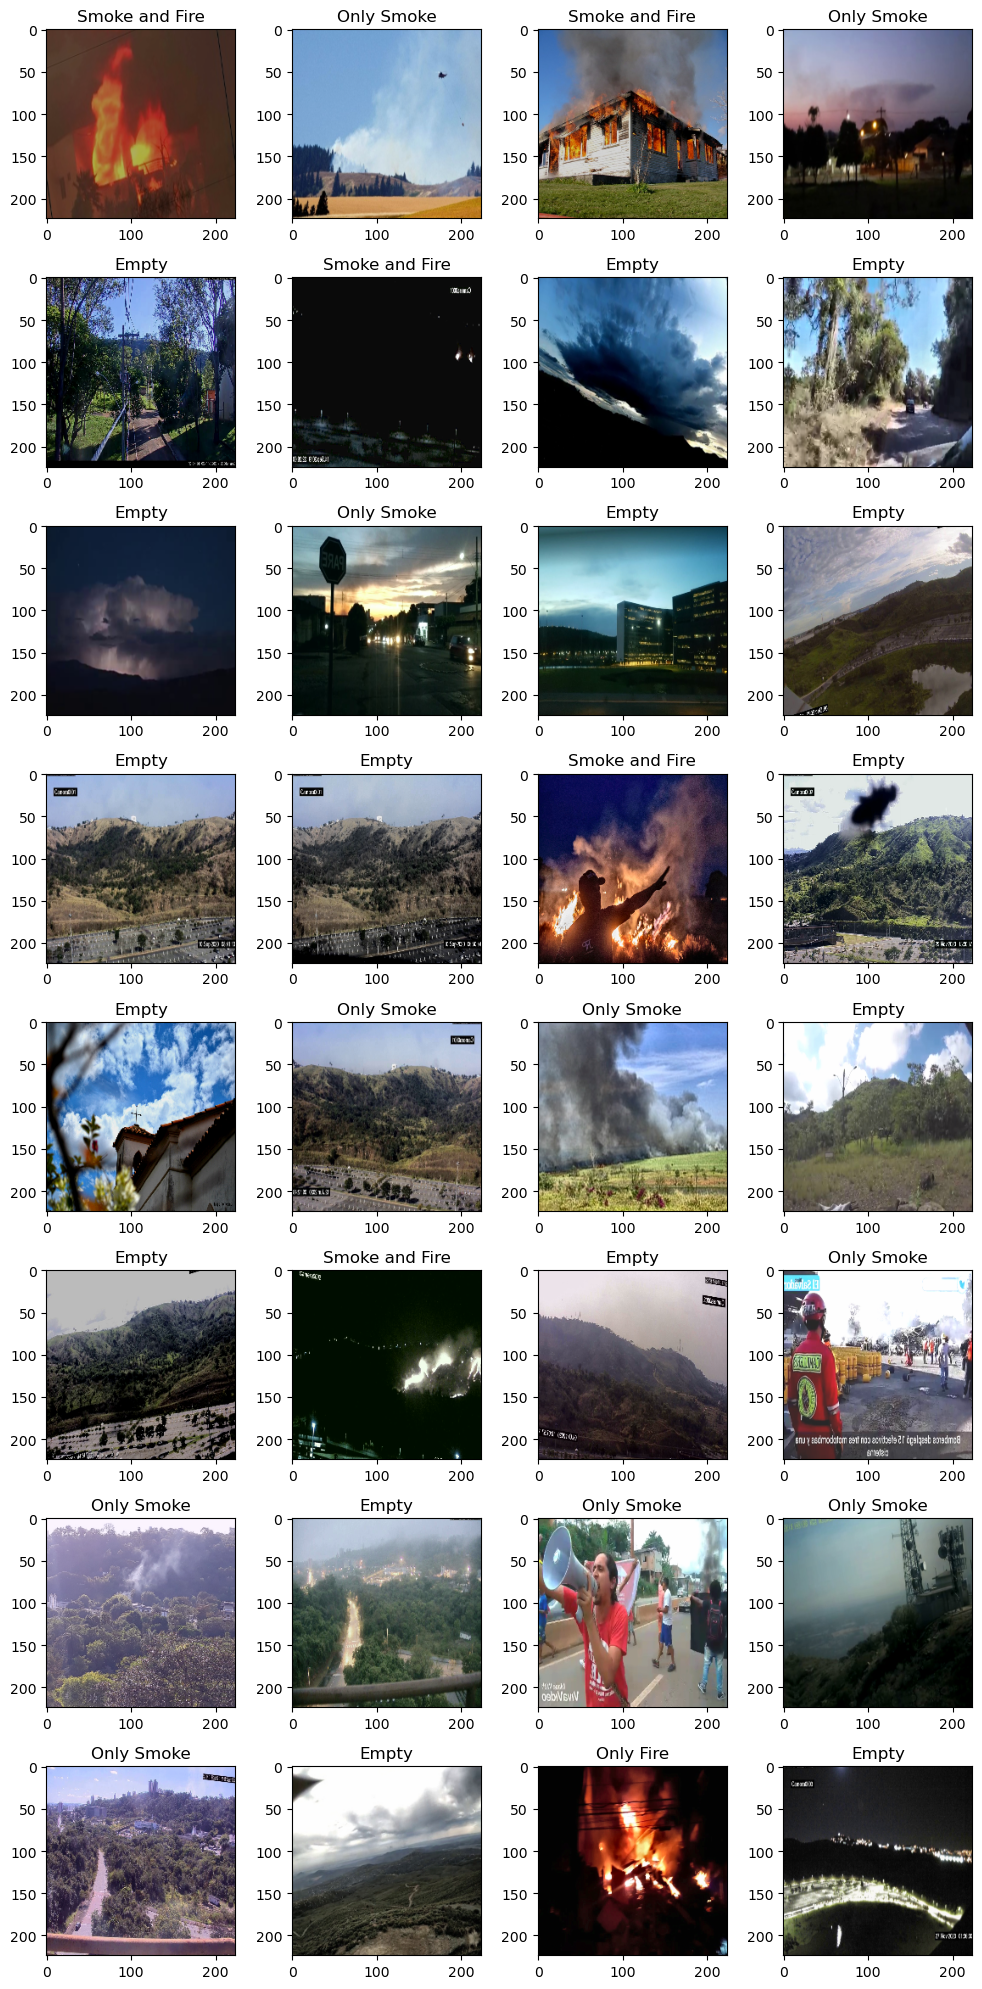

In [6]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Dataset Setup

In [7]:
train_loader = datasets.get_train_loader()
val_loader = datasets.get_val_loader()


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763

Train DFire dataset len: 17221

TRAIN FASDD UAV dataset
DFire Removed wrong images: 0
DFire empty images: 5994
DFire only smoke images: 2541
DFire only fire images: 105
DFire smoke and fire images: 3911

Train FASDD UAV dataset len: 12551

TRAIN FASDD CV dataset


DFire Removed wrong images: 0
DFire empty images: 19600
DFire only smoke images: 11708
DFire only fire images: 6276
DFire smoke and fire images: 10076

Train FASDD CV dataset len: 47660

Concatenate Train DFire and FASDD UAV datasets
Train dataset len: 29772
Concatenate with FASDD CV dataset
Train dataset len: 77432

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895

Test dataset len: 4306

TEST FASDD UAV dataset
DFire Removed wrong images: 0
DFire empty images: 1997
DFire only smoke images: 846
DFire only fire images: 35
DFire smoke and fire images: 1303

Test FASDD UAV dataset len: 4181

TEST FASDD CV dataset
DFire Removed wrong images: 0
DFire empty images: 6533
DFire only smoke images: 3902
DFire only fire images: 2091
DFire smoke and fire images: 3358

Test FASDD CV dataset len: 15884
Concatenate Test DFire and FASDD UAV datasets
Test dataset len: 8487
Concatenate wit

# Model Setup

In [8]:
if config.MODEL == "BED":
    print("Using BED Classifier")
    logger.info("\nUsing BED Classifier")
    model = models.BED_CLASSIFIER(num_classes=config.N_CLASSES).to(config.DEVICE)   
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

optimizer = optim.Adam(model.parameters(), 
                       lr=config.LEARNING_RATE, 
                       weight_decay=config.WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=config.FACTOR, 
                                                 patience=config.PATIENCE, 
                                                 threshold=config.THRES, 
                                                 threshold_mode='abs',
                                                 min_lr=config.MIN_LR)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier

Trainable parameters = 93266
Total parameters = 93266



### Check Model Shape

In [9]:
in_rand_np = np.random.rand(4, 3, config.IMG_H, config.IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=config.DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{model}')

Model shape is tensor([[-0.0538,  0.1546],
        [-0.1929,  0.0624],
        [-0.2272,  0.0526],
        [-0.2020,  0.0604]], device='cuda:0', grad_fn=<AddmmBackward0>)
BED Model Arquitecture
BED_CLASSIFIER(
  (model): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (dropout1): Dropout2d(p=0.3, inplace=False)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (dropout2): Dropout2d(p=0.3, inplace=False)
    (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv31): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn31)

# Torchinfo: model summary

### FP32 Model

In [10]:
print(summary(model, input_size=(1, 3, config.IMG_H, config.IMG_W)))
logger.info(summary(model, input_size=(1, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                   Output Shape              Param #
BED_CLASSIFIER                           [1, 2]                    --
├─Sequential: 1-1                        [1, 2]                    --
│    └─Conv2d: 2-1                       [1, 32, 224, 224]         864
│    └─BatchNorm2d: 2-2                  [1, 32, 224, 224]         64
│    └─ReLU: 2-3                         [1, 32, 224, 224]         --
│    └─Dropout2d: 2-4                    [1, 32, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 32, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 16, 112, 112]         4,608
│    └─BatchNorm2d: 2-7                  [1, 16, 112, 112]         32
│    └─ReLU: 2-8                         [1, 16, 112, 112]         --
│    └─Dropout2d: 2-9                    [1, 16, 112, 112]         --
│    └─MaxPool2d: 2-10                   [1, 16, 56, 56]           --
│    └─Conv2d: 2-11                      [1, 16, 56, 56]           256
│    └─Bat

# Load Model

Optimizer and Scheduler passed as None to load_checkpoint, so model start training with hyperparameters defined in config and not with hyperparameters of the model loaded.

In [11]:
model_path = 'BED_classifier__best_smoke__precision=0.935__epoch=87.pt'
epoch_saved = utils.load_checkpoint(model_path, model, None, None, config.DEVICE)

Loading Model. Trained during 87 epochs


# Loss Function

In [12]:
if config.LOSS_FN == "BCE":
    print(f'Loss Function: BCE')
    logger.info(f'\nLoss Function: BCE')
    print(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    logger.info(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    loss_fn = loss.BCE_LOSS(device=config.DEVICE, smoke_precision_weight=config.SMOKE_PRECISION_WEIGHT)
else:
    print("Wrong loss function")
    logger.info("Wrong loss function")
    raise SystemExit("Wrong loss function")

Loss Function: BCE
Smoke Precision Weight: 0.8


# Print and Log Config Values

In [13]:
''' ============================
    Print Config Values
============================ '''
print(f'\nDevice: {config.DEVICE}')
print(f'Learning Rate: {config.LEARNING_RATE}')
print(f'Weight Decay: {config.WEIGHT_DECAY}')
print(f'Batch Size: {config.BATCH_SIZE}')
print(f'IMG DIMS: ({config.IMG_H}, {config.IMG_W})')

logger.info(f'\nDevice: {config.DEVICE}')
logger.info(f'Learning Rate: {config.LEARNING_RATE}')
logger.info(f'Optimizer Weight Decay: {config.WEIGHT_DECAY}')
logger.info(f'Scheduler factor: {config.FACTOR}')
logger.info(f'Scheduler patience: {config.PATIENCE}')
logger.info(f'Scheduler threshold: {config.THRES}')
logger.info(f'Scheduler min learning rate: {config.MIN_LR}')
logger.info(f'Batch Size: {config.BATCH_SIZE}')
logger.info(f'W: {config.IMG_W}\nH: {config.IMG_H}')


Device: cuda
Learning Rate: 0.0001
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)


# Loss and Metrics Loggers and Plotters

In [14]:
train_losses_logger = utils.LogLosses()
train_metrics_logger = utils.LogMetrics()
lr_logger = utils.LogLR(log_path=config.PLOTS_FOLDER)

val_losses_logger = utils.LogLosses()
val_metrics_logger = utils.LogMetrics()

loss_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Loss')
metrics_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Metric')

# Neural Compressor: Add Manager

In [15]:
model.to('cpu')

accuracy_criterion = AccuracyCriterion(tolerable_loss=0.0075)
tuning_criterion = TuningCriterion(max_trials=600)
conf = QuantizationAwareTrainingConfig(
    device='cpu',
    backend="default", 
    tuning_criterion=tuning_criterion, 
    accuracy_criterion=accuracy_criterion,
    ) 

compression_manager = prepare_compression(model, conf)
#model = compression_manager.model

# Evaluation Function for Neural Compressor: Tuning Check

In [16]:
'''
Evaluation Function
'''
def validate(model):
    
    model.eval()
    model.to('cpu')

    for (x, y) in val_loader:
        #x, y = x.to(config.DEVICE), y.to(config.DEVICE)
        x, y = x.to('cpu'), y.to('cpu')
        out = model(x)

        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        f1 = metrics.f1_metric_cpu.update(yhat, y)
    
    f1 = metrics.f1_metric_cpu.compute()
    metrics.f1_metric_cpu.reset()
    
    f1_mean = ( f1[0].item() + f1[1].item() ) / 2
    
    model.to(config.DEVICE)
    
    return f1_mean

# Main Function

In [17]:
def train_loop(model):

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')
    
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = 0. #torch.tensor([0.])
    smoke_f1_min_save = 0.9 #torch.tensor([0.9])
    best_mean_f1 = 0.

    start_epoch = 0
    epochs_plot = []
    
    #****************** Quantization ******************#
    compression_manager.callbacks.on_train_begin()
    model.to(config.DEVICE)
    #**************************************************#
        
    for epoch in range(start_epoch, config.EPOCHS):

        print(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        
        #****************** Quantization ******************#
        compression_manager.callbacks.on_epoch_begin(epoch)
        #**************************************************#
        
        #====================== TRAINING ========================#
        current_lr = train_epoch_qat.get_lr(optimizer=optimizer)
        logger.info(f'Learning Rate = {current_lr:.6f}\n')
        lr_logger.log_lr(current_lr)
                
        train_losses, train_metrics = train_epoch_qat.train_fn(
            loader=train_loader, 
            model=model, 
            optimizer=optimizer, 
            loss_fn=loss_fn,
            device=config.DEVICE,
            cmp_mng=compression_manager)
        
        #****************** Quantization ******************#
        compression_manager.callbacks.on_epoch_end()
        #**************************************************#
        
        train_losses_logger.update_metrics(train_losses)
        train_metrics_logger.update_metrics(train_metrics)
                
        logger.info(utils.print_metrics_to_logger("TRAIN Stats", train_losses, train_metrics))
        
        #===================== VALIDATING =======================#
        with torch.no_grad():
            val_losses, val_metrics = val_epoch.eval_fn(
                loader=val_loader, 
                model=model,                         
                loss_fn=loss_fn,
                device=config.DEVICE)
            
            scheduler.step(val_losses['Total'])
            
            val_losses_logger.update_metrics(val_losses)
            val_metrics_logger.update_metrics(val_metrics)

            logger.info(utils.print_metrics_to_logger("VAL Stats", val_losses, val_metrics))
            
        epochs_plot.append(epoch)

        loss_plotter.plot_all_metrics(
            train_losses_logger.get_metrics(),
            val_losses_logger.get_metrics(),
            epochs_plot)

        metrics_plotter.plot_all_metrics(
            train_metrics_logger.get_metrics(),
            val_metrics_logger.get_metrics(),
            epochs_plot)

        lr_logger.plot_lr(epochs_plot)
        
        #======================= SAVING =========================#
        if ( (epoch+1) % 5 ) == 0:
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__5epoch.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
            
        if best_valid_loss > val_losses['Total']:
            best_valid_loss = val_losses['Total']
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"Saving model with new best validation loss: {best_valid_loss:.3f}")
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + 'best_loss'  + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < val_metrics['Precision'][0] ) and ( val_metrics['F1'][0] > smoke_f1_min_save ) :
            best_smoke_precision = val_metrics['Precision'][0]
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"Saving model with new best smoke precision: {best_smoke_precision:.3f}")
            save_precision_name = f'best_smoke__precision={np.round(best_smoke_precision, decimals=4)}__epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_precision_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  
            
        # Save model if precision > 0.9 and recall > 0.88
        if ( val_metrics['Precision'][0] > 0.9 ) and ( val_metrics['Recall'][0] > 0.88 ) :
            print("\nSaving model with precision > 0.9 and recall > 0.88")
            logger.info("Saving model with precision > 0.9 and recall > 0.88")
            save_pre_name = f'smoke__precision={np.round(val_metrics["Precision"][0], decimals=4)}__' 
            save_rec_name = f'recall={np.round(val_metrics["Recall"][0], decimals=4)}__'
            save_pre_rec_name = save_pre_name + save_rec_name + f'epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_pre_rec_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
            
        # Save model if best mean F1 increases
        val_f1_mean = (val_metrics['F1'][0] + val_metrics['F1'][1]) / 2
        if (val_f1_mean > best_mean_f1):
            best_mean_f1 = val_f1_mean
            print(f'Saving model with best Mean F1: {best_mean_f1:.4f}')
            logger.info(f'Saving model with best Mean F1: {best_mean_f1:.4f}')
            save_f1_name = 'best_mean_F1'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_f1_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)
        
        # Break if F1 mean is better than baseline model
        if (val_f1_mean > 0.9205):
            break
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), config.WEIGHTS_FOLDER + 'last_' + config.MODEL + '_classifier.pt') 
    
    model.to('cpu')
    #****************** Quantization ******************#
    compression_manager.callbacks.on_train_end()
    #**************************************************#
    #======================= FINISH =========================#
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [18]:
if __name__ == "__main__":
    
    model.to(config.DEVICE)

    q_model = fit(compression_manager=compression_manager, train_func=train_loop, eval_func=validate)
    
    q_model.to('cpu')
    model.to('cpu')
    compression_manager.save(config.RUN_FOLDER + "output_qat_tune")

2024-07-13 01:56:13 [INFO] Start auto tuning.
2024-07-13 01:56:13 [INFO] Execute the tuning process due to detect the evaluation function.
2024-07-13 01:56:13 [INFO] Adaptor has 5 recipes.
2024-07-13 01:56:13 [INFO] 0 recipes specified by user.
2024-07-13 01:56:13 [INFO] 3 recipes require future tuning.
2024-07-13 01:56:13 [INFO] *** Initialize auto tuning
2024-07-13 01:56:13 [WARNING] [Strategy] Please install `mpi4py` correctly if using distributed tuning; otherwise, ignore this warning.
/opt/conda/envs/pytorch_23/lib/python3.10/site-packages/torch/ao/quantization/fx/fuse.py:56: UserWarning: Passing a fuse_custom_config_dict to fuse is deprecated and will not be supported in a future version. Please pass in a FuseCustomConfig instead.
  warnings.warn(
2024-07-13 01:56:13 [INFO] Attention Blocks: 0
2024-07-13 01:56:13 [INFO] FFN Blocks: 0
2024-07-13 01:56:13 [INFO] Pass query framework capability elapsed time: 24.4 ms
2024-07-13 01:56:13 [INFO] Get FP32 model baseline.
2024-07-13 02:2


***Start Training: 02:22:01


=== EPOCH 0/39 ===
Learning Rate = 0.0001



Training:   0%|                                                                                           | 0/1209 [00:00<?, ?it/s]/opt/conda/envs/pytorch_23/lib/python3.10/site-packages/torch/ao/quantization/fake_quantize.py:353: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905979055/work/aten/src/ATen/native/ReduceAllOps.cpp:71.)
  return torch.fused_moving_avg_obs_fake_quant(
/opt/conda/envs/pytorch_23/lib/python3.10/site-packages/torch/ao/quantization/fake_quantize.py:353: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905979055/work/aten/src/ATen/native/TensorCompare.cpp:687.)
  return torch.fused_moving_avg_obs_fake_quant(
Training:

Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.013      |11.390      |6.623       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.796      |13.631      |7.164       
SMOKE -> Precision: 0.910 - Recall: 0.882 - Accuracy: 0.903 - F1: 0.896
FIRE -> Precision: 0.908 - Recall: 0.971 - Accuracy: 0.959 - F1: 0.938

Saving model with new best validation loss: 20.796

Saving model with precision > 0.9 and recall > 0.88
Saving model with best Mean F1: 0.9169

=== EPOCH 1/39 ===
Learning Rate = 0.0001



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:48<00:00,  7.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.720      |11.202      |6.518       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.554      |13.411      |7.143       
SMOKE -> Precision: 0.915 - Recall: 0.882 - Accuracy: 0.906 - F1: 0.898
FIRE -> Precision: 0.911 - Recall: 0.969 - Accuracy: 0.959 - F1: 0.939

Saving model with new best validation loss: 20.554

Saving model with precision > 0.9 and recall > 0.88
Saving model with best Mean F1: 0.9187

=== EPOCH 2/39 ===
Learning Rate = 0.0001



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:50<00:00,  7.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.990      |11.326      |6.664       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.365      |13.445      |6.920       
SMOKE -> Precision: 0.925 - Recall: 0.867 - Accuracy: 0.904 - F1: 0.895
FIRE -> Precision: 0.914 - Recall: 0.967 - Accuracy: 0.960 - F1: 0.940

Saving model with new best validation loss: 20.365

=== EPOCH 3/39 ===
Learning Rate = 0.0001



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:49<00:00,  7.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.012      |11.432      |6.580       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.306      |13.264      |7.041       
SMOKE -> Precision: 0.920 - Recall: 0.876 - Accuracy: 0.906 - F1: 0.897
FIRE -> Precision: 0.914 - Recall: 0.968 - Accuracy: 0.960 - F1: 0.940

Saving model with new best validation loss: 20.306

=== EPOCH 4/39 ===
Learning Rate = 0.0001



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:50<00:00,  7.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.955      |11.335      |6.620       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.656      |13.660      |6.996       
SMOKE -> Precision: 0.913 - Recall: 0.879 - Accuracy: 0.903 - F1: 0.895
FIRE -> Precision: 0.914 - Recall: 0.969 - Accuracy: 0.960 - F1: 0.941

=== EPOCH 5/39 ===
Learning Rate = 0.0001



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:49<00:00,  7.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.095      |11.397      |6.698       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.567      |13.469      |7.098       
SMOKE -> Precision: 0.912 - Recall: 0.879 - Accuracy: 0.903 - F1: 0.895
FIRE -> Precision: 0.912 - Recall: 0.967 - Accuracy: 0.959 - F1: 0.939

=== EPOCH 6/39 ===
Learning Rate = 0.0001



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:49<00:00,  7.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.981      |11.449      |6.532       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.130      |13.224      |6.906       
SMOKE -> Precision: 0.925 - Recall: 0.869 - Accuracy: 0.905 - F1: 0.896
FIRE -> Precision: 0.915 - Recall: 0.968 - Accuracy: 0.960 - F1: 0.941

Saving model with new best validation loss: 20.130

=== EPOCH 7/39 ===
Learning Rate = 0.0001



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:49<00:00,  7.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.974      |11.418      |6.556       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.654      |13.402      |7.252       
SMOKE -> Precision: 0.920 - Recall: 0.872 - Accuracy: 0.904 - F1: 0.896
FIRE -> Precision: 0.907 - Recall: 0.973 - Accuracy: 0.959 - F1: 0.939

=== EPOCH 8/39 ===
Learning Rate = 0.0001



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:50<00:00,  7.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.019      |11.384      |6.634       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.678      |13.403      |7.274       
SMOKE -> Precision: 0.917 - Recall: 0.876 - Accuracy: 0.905 - F1: 0.896
FIRE -> Precision: 0.907 - Recall: 0.973 - Accuracy: 0.959 - F1: 0.939

=== EPOCH 9/39 ===
Learning Rate = 0.0001



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:50<00:00,  7.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.891      |11.279      |6.613       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.408      |13.390      |7.018       
SMOKE -> Precision: 0.915 - Recall: 0.882 - Accuracy: 0.906 - F1: 0.898
FIRE -> Precision: 0.913 - Recall: 0.971 - Accuracy: 0.960 - F1: 0.941

Saving model with precision > 0.9 and recall > 0.88
Saving model with best Mean F1: 0.9194

=== EPOCH 10/39 ===
Learning Rate = 8e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:49<00:00,  7.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.792      |11.320      |6.472       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.543      |13.365      |7.178       
SMOKE -> Precision: 0.928 - Recall: 0.865 - Accuracy: 0.904 - F1: 0.895
FIRE -> Precision: 0.909 - Recall: 0.970 - Accuracy: 0.959 - F1: 0.939

=== EPOCH 11/39 ===
Learning Rate = 8e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:51<00:00,  7.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.815      |11.310      |6.505       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.080      |13.305      |6.774       
SMOKE -> Precision: 0.923 - Recall: 0.870 - Accuracy: 0.905 - F1: 0.896
FIRE -> Precision: 0.917 - Recall: 0.966 - Accuracy: 0.961 - F1: 0.941

Saving model with new best validation loss: 20.080

=== EPOCH 12/39 ===
Learning Rate = 8e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:49<00:00,  7.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.673      |11.279      |6.393       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.226      |13.274      |6.952       
SMOKE -> Precision: 0.927 - Recall: 0.869 - Accuracy: 0.906 - F1: 0.897
FIRE -> Precision: 0.913 - Recall: 0.970 - Accuracy: 0.960 - F1: 0.941

=== EPOCH 13/39 ===
Learning Rate = 8e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:50<00:00,  7.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.013      |11.453      |6.561       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.478      |13.458      |7.020       
SMOKE -> Precision: 0.917 - Recall: 0.879 - Accuracy: 0.905 - F1: 0.898
FIRE -> Precision: 0.915 - Recall: 0.968 - Accuracy: 0.961 - F1: 0.941

=== EPOCH 14/39 ===
Learning Rate = 8e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:50<00:00,  7.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.911      |11.350      |6.561       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.266      |13.507      |6.759       
SMOKE -> Precision: 0.916 - Recall: 0.877 - Accuracy: 0.904 - F1: 0.896
FIRE -> Precision: 0.919 - Recall: 0.966 - Accuracy: 0.961 - F1: 0.942

=== EPOCH 15/39 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:50<00:00,  7.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.882      |11.307      |6.574       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.136      |13.681      |7.455       
SMOKE -> Precision: 0.909 - Recall: 0.882 - Accuracy: 0.903 - F1: 0.895
FIRE -> Precision: 0.905 - Recall: 0.972 - Accuracy: 0.958 - F1: 0.937

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 16/39 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:49<00:00,  7.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.990      |11.354      |6.637       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.865      |13.535      |7.331       
SMOKE -> Precision: 0.919 - Recall: 0.872 - Accuracy: 0.903 - F1: 0.895
FIRE -> Precision: 0.908 - Recall: 0.971 - Accuracy: 0.959 - F1: 0.938

=== EPOCH 17/39 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:50<00:00,  7.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.997      |11.327      |6.670       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.925      |13.542      |7.383       
SMOKE -> Precision: 0.912 - Recall: 0.881 - Accuracy: 0.904 - F1: 0.896
FIRE -> Precision: 0.907 - Recall: 0.970 - Accuracy: 0.958 - F1: 0.938

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 18/39 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:50<00:00,  7.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.929      |11.276      |6.654       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.462      |13.367      |7.095       
SMOKE -> Precision: 0.922 - Recall: 0.872 - Accuracy: 0.905 - F1: 0.896
FIRE -> Precision: 0.911 - Recall: 0.970 - Accuracy: 0.959 - F1: 0.940

=== EPOCH 19/39 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:49<00:00,  7.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.860      |11.254      |6.607       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.241      |13.336      |6.906       
SMOKE -> Precision: 0.913 - Recall: 0.881 - Accuracy: 0.905 - F1: 0.897
FIRE -> Precision: 0.914 - Recall: 0.970 - Accuracy: 0.960 - F1: 0.941

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 20/39 ===
Learning Rate = 5.120000000000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:49<00:00,  7.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.036      |11.465      |6.571       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.024      |13.640      |7.384       
SMOKE -> Precision: 0.906 - Recall: 0.886 - Accuracy: 0.903 - F1: 0.896
FIRE -> Precision: 0.906 - Recall: 0.971 - Accuracy: 0.958 - F1: 0.937

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 21/39 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:50<00:00,  7.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.727      |11.185      |6.542       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.669      |13.610      |7.059       
SMOKE -> Precision: 0.911 - Recall: 0.884 - Accuracy: 0.905 - F1: 0.897
FIRE -> Precision: 0.912 - Recall: 0.969 - Accuracy: 0.960 - F1: 0.940

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 22/39 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:50<00:00,  7.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.982      |11.359      |6.623       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.265      |13.311      |6.955       
SMOKE -> Precision: 0.923 - Recall: 0.872 - Accuracy: 0.905 - F1: 0.897
FIRE -> Precision: 0.913 - Recall: 0.969 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 23/39 ===
Learning Rate = 4.0960000000000014e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:49<00:00,  7.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.960      |11.359      |6.602       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.513      |13.418      |7.095       
SMOKE -> Precision: 0.919 - Recall: 0.876 - Accuracy: 0.905 - F1: 0.897
FIRE -> Precision: 0.912 - Recall: 0.969 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 24/39 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:49<00:00,  7.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.136      |11.394      |6.742       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.304      |13.356      |6.948       
SMOKE -> Precision: 0.917 - Recall: 0.876 - Accuracy: 0.904 - F1: 0.896
FIRE -> Precision: 0.914 - Recall: 0.970 - Accuracy: 0.961 - F1: 0.941

=== EPOCH 25/39 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:50<00:00,  7.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.872      |11.366      |6.506       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.346      |13.330      |7.016       
SMOKE -> Precision: 0.920 - Recall: 0.874 - Accuracy: 0.905 - F1: 0.896
FIRE -> Precision: 0.916 - Recall: 0.967 - Accuracy: 0.960 - F1: 0.941

=== EPOCH 26/39 ===
Learning Rate = 3.2768000000000016e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:50<00:00,  7.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.018      |11.309      |6.710       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.381      |13.401      |6.979       
SMOKE -> Precision: 0.920 - Recall: 0.876 - Accuracy: 0.905 - F1: 0.897
FIRE -> Precision: 0.912 - Recall: 0.970 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 27/39 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:50<00:00,  7.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.115      |11.456      |6.660       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.823      |13.616      |7.207       
SMOKE -> Precision: 0.913 - Recall: 0.882 - Accuracy: 0.905 - F1: 0.897
FIRE -> Precision: 0.909 - Recall: 0.972 - Accuracy: 0.959 - F1: 0.939

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 28/39 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:50<00:00,  7.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.772      |11.338      |6.434       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.213      |13.234      |6.979       
SMOKE -> Precision: 0.927 - Recall: 0.867 - Accuracy: 0.905 - F1: 0.896
FIRE -> Precision: 0.913 - Recall: 0.969 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 29/39 ===
Learning Rate = 2.6214400000000015e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:51<00:00,  7.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.010      |11.481      |6.529       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.307      |13.417      |6.890       
SMOKE -> Precision: 0.913 - Recall: 0.887 - Accuracy: 0.907 - F1: 0.900
FIRE -> Precision: 0.913 - Recall: 0.970 - Accuracy: 0.960 - F1: 0.941

Saving model with precision > 0.9 and recall > 0.88
Saving model with best Mean F1: 0.9202

=== EPOCH 30/39 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:51<00:00,  7.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.001      |11.399      |6.602       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.912      |13.249      |6.663       
SMOKE -> Precision: 0.925 - Recall: 0.871 - Accuracy: 0.906 - F1: 0.897
FIRE -> Precision: 0.920 - Recall: 0.967 - Accuracy: 0.962 - F1: 0.943

Saving model with new best validation loss: 19.912

=== EPOCH 31/39 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:52<00:00,  7.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.960      |11.425      |6.535       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.982      |13.175      |6.807       
SMOKE -> Precision: 0.926 - Recall: 0.870 - Accuracy: 0.906 - F1: 0.897
FIRE -> Precision: 0.915 - Recall: 0.972 - Accuracy: 0.962 - F1: 0.943

=== EPOCH 32/39 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:53<00:00,  6.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.897      |11.249      |6.648       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.068      |13.377      |6.691       
SMOKE -> Precision: 0.920 - Recall: 0.872 - Accuracy: 0.904 - F1: 0.895
FIRE -> Precision: 0.919 - Recall: 0.968 - Accuracy: 0.962 - F1: 0.943

=== EPOCH 33/39 ===
Learning Rate = 2.0971520000000012e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [02:58<00:00,  6.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.986      |11.404      |6.582       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:22<00:00, 16.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.267      |13.210      |7.057       
SMOKE -> Precision: 0.919 - Recall: 0.875 - Accuracy: 0.905 - F1: 0.897
FIRE -> Precision: 0.913 - Recall: 0.970 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 34/39 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:12<00:00,  6.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.939      |11.364      |6.575       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.501      |13.384      |7.117       
SMOKE -> Precision: 0.924 - Recall: 0.870 - Accuracy: 0.905 - F1: 0.896
FIRE -> Precision: 0.911 - Recall: 0.970 - Accuracy: 0.959 - F1: 0.940

=== EPOCH 35/39 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:20<00:00,  6.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.863      |11.206      |6.657       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.345      |13.614      |7.731       
SMOKE -> Precision: 0.912 - Recall: 0.880 - Accuracy: 0.904 - F1: 0.896
FIRE -> Precision: 0.900 - Recall: 0.973 - Accuracy: 0.956 - F1: 0.935

Saving model with precision > 0.9 and recall > 0.88

=== EPOCH 36/39 ===
Learning Rate = 1.677721600000001e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:20<00:00,  6.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.973      |11.358      |6.615       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.328      |13.301      |7.028       
SMOKE -> Precision: 0.918 - Recall: 0.875 - Accuracy: 0.904 - F1: 0.896
FIRE -> Precision: 0.913 - Recall: 0.969 - Accuracy: 0.960 - F1: 0.940

=== EPOCH 37/39 ===
Learning Rate = 1.3421772800000009e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:21<00:00,  6.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.000      |11.401      |6.599       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.620      |13.440      |7.180       
SMOKE -> Precision: 0.921 - Recall: 0.871 - Accuracy: 0.904 - F1: 0.895
FIRE -> Precision: 0.906 - Recall: 0.974 - Accuracy: 0.959 - F1: 0.939

=== EPOCH 38/39 ===
Learning Rate = 1.3421772800000009e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████| 1209/1209 [03:20<00:00,  6.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.951      |11.393      |6.558       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:23<00:00, 16.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.794      |13.197      |6.596       
SMOKE -> Precision: 0.919 - Recall: 0.880 - Accuracy: 0.907 - F1: 0.899
FIRE -> Precision: 0.923 - Recall: 0.964 - Accuracy: 0.962 - F1: 0.943


2024-07-13 04:30:31 [INFO] Training finished!



Saving model with new best validation loss: 19.794

Saving model with precision > 0.9 and recall > 0.88
Saving model with best Mean F1: 0.9212

***Script finished: 04:30:31

Time elapsed: 2:08:29.808889


2024-07-13 04:30:32 [INFO] |*********Mixed Precision Statistics********|
2024-07-13 04:30:32 [INFO] +---------------------+-------+------+------+
2024-07-13 04:30:32 [INFO] |       Op Type       | Total | INT8 | FP32 |
2024-07-13 04:30:32 [INFO] +---------------------+-------+------+------+
2024-07-13 04:30:32 [INFO] | quantize_per_tensor |   4   |  4   |  0   |
2024-07-13 04:30:32 [INFO] |      ConvReLU2d     |   12  |  12  |  0   |
2024-07-13 04:30:32 [INFO] |      dequantize     |   4   |  4   |  0   |
2024-07-13 04:30:32 [INFO] |      MaxPool2d      |   3   |  3   |  0   |
2024-07-13 04:30:32 [INFO] |  AdaptiveAvgPool2d  |   1   |  1   |  0   |
2024-07-13 04:30:32 [INFO] |       Dropout       |   1   |  0   |  1   |
2024-07-13 04:30:32 [INFO] |      LinearReLU     |   1   |  1   |  0   |
2024-07-13 04:30:32 [INFO] |        Linear       |   1   |  1   |  0   |
2024-07-13 04:30:32 [INFO] +---------------------+-------+------+------+
2024-07-13 04:30:32 [INFO] Pass quantize model elap

In [19]:
from neural_compressor.config import Torch2ONNXConfig

int8_onnx_config = Torch2ONNXConfig(
    dtype="int8",
    opset_version=14,
    quant_format="QOperator",  # or QDQ
    example_inputs=torch.randn(1, 3, 224, 224),
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
)
q_model.to('cpu')
q_model.export(config.RUN_FOLDER + "int8-model-bnAffine_qat_v1.onnx", int8_onnx_config)

2024-07-13 04:34:05 [INFO] **************************************************************************************************
2024-07-13 04:34:05 [INFO] The INT8 ONNX Model exported to path: experiments/v11_Tuning_fasdd/int8-model-bnAffine_qat_v1.onnx
2024-07-13 04:34:05 [INFO] **************************************************************************************************


In [21]:
print(q_model)

PyTorchFXModel(
  (_model): GraphModule(
    (model): Module(
      (conv1): QuantizedConvReLU2d(3, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.05421232804656029, zero_point=0, padding=(1, 1))
      (dropout1): Dropout2d(p=0.3, inplace=False)
      (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2): QuantizedConvReLU2d(32, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.06804659217596054, zero_point=0, padding=(1, 1))
      (dropout2): Dropout2d(p=0.3, inplace=False)
      (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv31): QuantizedConvReLU2d(16, 16, kernel_size=(1, 1), stride=(1, 1), scale=0.04585981369018555, zero_point=0)
      (conv32): QuantizedConvReLU2d(16, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.056080859154462814, zero_point=0, padding=(1, 1))
      (conv33): QuantizedConvReLU2d(32, 32, kernel_size=(1, 1), stride=(1, 1), scale=0.04767340049147606, zero_point=0)
      

In [22]:
sparse = q_model.report_sparsity()
print(sparse)

(                                            Name           Shape  NNZ (dense)  \
0                             model.conv1.weight   [32, 3, 3, 3]          861   
1                             model.conv2.weight  [16, 32, 3, 3]         4550   
2                            model.conv31.weight  [16, 16, 1, 1]          252   
3                            model.conv32.weight  [32, 16, 3, 3]         4407   
4                            model.conv33.weight  [32, 32, 1, 1]          988   
5                            model.conv34.weight  [64, 32, 3, 3]        17665   
6                            model.conv41.weight  [32, 64, 1, 1]         1911   
7                            model.conv42.weight  [64, 32, 3, 3]        17670   
8                            model.conv43.weight  [32, 64, 1, 1]         2033   
9                            model.conv44.weight  [64, 32, 3, 3]        16553   
10                           model.conv45.weight  [32, 64, 1, 1]         1267   
11                         

In [23]:
q_model.get_all_weight_names

<bound method PyTorchBaseModel.get_all_weight_names of PyTorchFXModel(
  (_model): GraphModule(
    (model): Module(
      (conv1): QuantizedConvReLU2d(3, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.05421232804656029, zero_point=0, padding=(1, 1))
      (dropout1): Dropout2d(p=0.3, inplace=False)
      (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2): QuantizedConvReLU2d(32, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.06804659217596054, zero_point=0, padding=(1, 1))
      (dropout2): Dropout2d(p=0.3, inplace=False)
      (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv31): QuantizedConvReLU2d(16, 16, kernel_size=(1, 1), stride=(1, 1), scale=0.04585981369018555, zero_point=0)
      (conv32): QuantizedConvReLU2d(16, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.056080859154462814, zero_point=0, padding=(1, 1))
      (conv33): QuantizedConvReLU2d(32, 32, kernel_size=(1, 1), stride=

In [24]:
q_model.q_config

{'op': OrderedDict([(('model.conv1', 'Conv2d'),
               {'weight': {'dtype': 'int8',
                 'scheme': 'sym',
                 'granularity': 'per_channel',
                 'algorithm': 'minmax'},
                'activation': {'dtype': 'uint8',
                 'quant_mode': 'static',
                 'scheme': 'asym',
                 'granularity': 'per_tensor',
                 'algorithm': 'minmax',
                 'scale': 0.05421232804656029,
                 'zero_point': 0}}),
              (('model.conv2', 'Conv2d'),
               {'weight': {'dtype': 'int8',
                 'scheme': 'sym',
                 'granularity': 'per_channel',
                 'algorithm': 'minmax'},
                'activation': {'dtype': 'uint8',
                 'quant_mode': 'static',
                 'scheme': 'asym',
                 'granularity': 'per_tensor',
                 'algorithm': 'minmax',
                 'scale': 0.06804659217596054,
                 'zero_po

In [26]:
graph_ex = q_model.graph_info
graph_ex

{'model.conv1': 'Conv2d',
 'model.conv2': 'Conv2d',
 'model.conv31': 'Conv2d',
 'model.conv32': 'Conv2d',
 'model.conv33': 'Conv2d',
 'model.conv34': 'Conv2d',
 'model.conv41': 'Conv2d',
 'model.conv42': 'Conv2d',
 'model.conv43': 'Conv2d',
 'model.conv44': 'Conv2d',
 'model.conv45': 'Conv2d',
 'model.conv46': 'Conv2d',
 'model.dropout5': 'Dropout',
 'model.linear51': 'Linear',
 'model.linear52': 'Linear'}